In [ ]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)


In [ ]:
df_train = pd.read_csv("../data/processed/numeric_train_data.csv")
df_train.head(5)

df_val = pd.read_csv("../data/processed/numeric_val_data.csv")
df_val

,chroma_1,chroma_2,chroma_3,chroma_4,chroma_5,chroma_6,chroma_7,chroma_8,chroma_9,chroma_10,...,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,mfcc_20,label
0,0.539667,0.705159,0.649134,0.583651,0.531421,0.561278,0.453441,0.474912,0.456864,0.567574,...,0.316943,0.564993,0.092125,0.599576,0.388226,0.685851,0.370379,0.824795,0.299102,0
1,0.700929,0.910526,0.769736,0.831898,0.789822,0.678607,0.666799,0.743293,0.607547,0.605180,...,0.373482,0.603531,0.473667,0.846925,0.503283,0.623375,0.314519,0.700598,0.456883,0
2,0.709038,0.791240,0.661102,0.667024,0.683870,0.700922,0.633543,0.628824,0.643679,0.689421,...,0.415091,0.618660,0.464444,0.719470,0.520133,0.598141,0.388956,0.734982,0.370067,0
3,0.530169,0.716288,0.642201,0.794942,0.810297,0.778762,0.672078,0.716846,0.748976,0.813740,...,0.515809,0.680099,0.411544,0.792083,0.590471,0.626973,0.399913,0.877330,0.594645,0
4,0.606761,0.698771,0.700411,0.806784,0.815829,0.724553,0.583545,0.693354,0.571397,0.739391,...,0.498413,0.716406,0.419340,0.653179,0.441496,0.515069,0.322138,0.734589,0.426383,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7637,0.437047,0.555612,0.487570,0.609676,0.565383,0.621709,0.705636,0.768562,0.671040,0.537779,...,0.625622,0.357911,0.573465,0.500598,0.638202,0.485155,0.570285,0.447402,0.553567,1
7638,0.286778,0.296154,0.394823,0.698401,0.685904,0.722048,0.569149,0.679403,0.785093,0.608060,...,0.631064,0.517908,0.599596,0.580383,0.628368,0.310323,0.410315,0.638640,0.454653,1
7639,0.386399,0.561362,0.596431,0.696707,0.591178,0.571610,0.670914,0.818815,0.770197,0.577832,...,0.660530,0.477367,0.563112,0.509746,0.566321,0.331353,0.613877,0.637037,0.532293,1
7640,0.441040,0.602926,0.523737,0.542881,0.670638,0.679416,0.491501,0.493725,0.556791,0.813018,...,0.529096,0.396013,0.642967,0.527645,0.665692,0.178644,0.453539,0.477542,0.553312,1


In [ ]:
# Pisah fitur dan label
X_train = df_train.iloc[:, :-1]
y_train = df_train.iloc[:, -1]

X_val = df_val.iloc[:, :-1]
y_val = df_val.iloc[:, -1]

# Output path
output_path = '../data/output/rfe_val_results_rf.csv'

# Hapus file jika sudah ada
if os.path.exists(output_path):
    os.remove(output_path)

# Loop dari 1 sampai seluruh jumlah fitur
for k in tqdm(range(1, X_train.shape[1] + 1)):

    # Inisialisasi model dan RFE
    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rfe = RFE(estimator=rf, n_features_to_select=k, step=1)

    # Fit dan transformasi
    rfe.fit(X_train, y_train)
    X_train_rfe = rfe.transform(X_train)
    X_val_rfe = rfe.transform(X_val)

    # Fit model dan prediksi
    rf.fit(X_train_rfe, y_train)
    y_pred = rf.predict(X_val_rfe)
    acc = accuracy_score(y_val, y_pred)

    # Simpan hasil
    pd.DataFrame([{
        "n_features": k,
        "accuracy": acc
    }]).to_csv(output_path, mode='a', header=not os.path.exists(output_path), index=False)

    print(f"✔️ Feature set with {k} features evaluated.")


✅ Optimal number of features: 29
📈 Highest validation accuracy: 0.9487


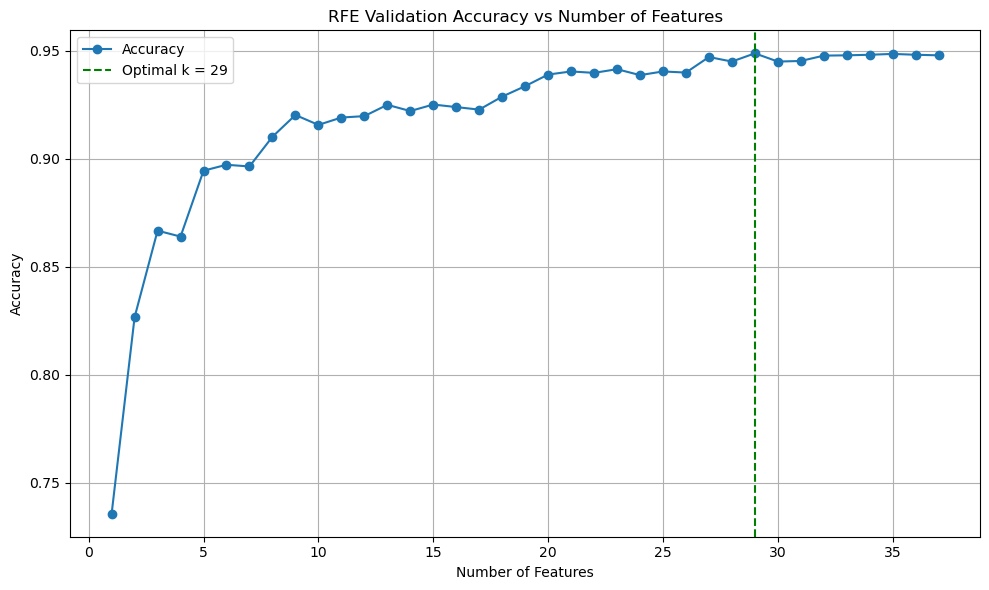

In [ ]:
# Load hasil RFE
df = pd.read_csv('../data/output/rfe_val_results_rf.csv')

# Karena tidak ada repetisi, kita tetap tambahkan kolom std dummy = 0
df['std'] = 0

# Ringkas ke dalam format summary
summary = df.groupby('n_features')['accuracy'].agg(['mean']).reset_index()
summary['std'] = 0  # tetap ditambahkan untuk jaga kompatibilitas visualisasi

# Cari jumlah fitur dengan akurasi tertinggi
best_mean = summary['mean'].max()
k_optimal = summary[summary['mean'] == best_mean]['n_features'].min()

print(f"✅ Optimal number of features: {k_optimal}")
print(f"📈 Highest validation accuracy: {best_mean:.4f}")

# Visualisasi
plt.figure(figsize=(10, 6))
plt.plot(summary['n_features'], summary['mean'], marker='o', label='Accuracy')
plt.axvline(x=k_optimal, color='g', linestyle='--', label=f'Optimal k = {k_optimal}')
plt.title('RFE Validation Accuracy vs Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
# Inisialisasi model
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Pastikan X_train dalam bentuk DataFrame
feature_names = X_train.columns

k=5
rfe = RFE(estimator=rf, n_features_to_select=k, step=1)
rfe.fit(X_train, y_train)

# Ambil nama fitur yang terpilih
selected_features = feature_names[rfe.support_]

print(f"\nFitur terpilih untuk k={k}:")
for i, name in enumerate(selected_features, 1):
    print(f"{i}. {name}")



Fitur terpilih untuk k=5:
1. mfcc_3
2. mfcc_6
3. mfcc_15
4. mfcc_17
5. mfcc_19


In [11]:
selected_features

Index(['chroma_1', 'chroma_2', 'chroma_3', 'chroma_4', 'chroma_8', 'chroma_9',
       'chroma_11', 'chroma_12', 'spectral_bandwidth_mean',
       'spectral_rolloff_mean', 'mfcc_1', 'mfcc_3', 'mfcc_4', 'mfcc_5',
       'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12',
       'mfcc_13', 'mfcc_14', 'mfcc_15', 'mfcc_16', 'mfcc_17', 'mfcc_18',
       'mfcc_19', 'mfcc_20'],
      dtype='object')

## SVM Algorithm

In [ ]:
# Output path
output_path = '../data/output/rfe_val_results_svm_2.csv'

# Hapus file jika sudah ada
if os.path.exists(output_path):
    os.remove(output_path)

# Loop jumlah fitur (1 sampai seluruh fitur)
for k in tqdm(range(1, X_train.shape[1] + 1)):

    # Inisialisasi model dan RFE
    svm = LinearSVC(C=1.0, max_iter=5000, dual=False, random_state=42)
    rfe = RFE(estimator=svm, n_features_to_select=k, step=1)

    # Fit RFE dan transform
    rfe.fit(X_train, y_train)
    X_train_rfe = rfe.transform(X_train)
    X_val_rfe = rfe.transform(X_val)

    # Fit model SVM dan prediksi ke validasi
    svm.fit(X_train_rfe, y_train)
    y_pred = svm.predict(X_val_rfe)
    acc = accuracy_score(y_val, y_pred)

    # Simpan hasil
    pd.DataFrame([{
        "n_features": k,
        "accuracy": acc
    }]).to_csv(output_path, mode='a', header=not os.path.exists(output_path), index=False)

    print(f"✔️ Feature set with {k} features evaluated.")

  3%|▎         | 1/37 [00:00<00:20,  1.75it/s]

✔️ Feature set with 1 features evaluated.


  5%|▌         | 2/37 [00:01<00:20,  1.69it/s]

✔️ Feature set with 2 features evaluated.


  8%|▊         | 3/37 [00:01<00:21,  1.60it/s]

✔️ Feature set with 3 features evaluated.


 11%|█         | 4/37 [00:02<00:20,  1.57it/s]

✔️ Feature set with 4 features evaluated.


 14%|█▎        | 5/37 [00:03<00:19,  1.64it/s]

✔️ Feature set with 5 features evaluated.


 16%|█▌        | 6/37 [00:03<00:18,  1.69it/s]

✔️ Feature set with 6 features evaluated.


 19%|█▉        | 7/37 [00:04<00:17,  1.70it/s]

✔️ Feature set with 7 features evaluated.


 22%|██▏       | 8/37 [00:04<00:16,  1.73it/s]

✔️ Feature set with 8 features evaluated.


 24%|██▍       | 9/37 [00:05<00:16,  1.75it/s]

✔️ Feature set with 9 features evaluated.


 27%|██▋       | 10/37 [00:05<00:15,  1.75it/s]

✔️ Feature set with 10 features evaluated.


 30%|██▉       | 11/37 [00:06<00:14,  1.82it/s]

✔️ Feature set with 11 features evaluated.


 32%|███▏      | 12/37 [00:06<00:13,  1.89it/s]

✔️ Feature set with 12 features evaluated.


 35%|███▌      | 13/37 [00:07<00:12,  1.95it/s]

✔️ Feature set with 13 features evaluated.


 38%|███▊      | 14/37 [00:07<00:11,  1.98it/s]

✔️ Feature set with 14 features evaluated.


 41%|████      | 15/37 [00:08<00:10,  2.02it/s]

✔️ Feature set with 15 features evaluated.


 43%|████▎     | 16/37 [00:08<00:10,  1.95it/s]

✔️ Feature set with 16 features evaluated.


 46%|████▌     | 17/37 [00:09<00:09,  2.01it/s]

✔️ Feature set with 17 features evaluated.


 49%|████▊     | 18/37 [00:09<00:09,  2.06it/s]

✔️ Feature set with 18 features evaluated.


 51%|█████▏    | 19/37 [00:10<00:08,  2.13it/s]

✔️ Feature set with 19 features evaluated.


 54%|█████▍    | 20/37 [00:10<00:07,  2.17it/s]

✔️ Feature set with 20 features evaluated.


 57%|█████▋    | 21/37 [00:11<00:07,  2.14it/s]

✔️ Feature set with 21 features evaluated.


 59%|█████▉    | 22/37 [00:11<00:06,  2.29it/s]

✔️ Feature set with 22 features evaluated.


 62%|██████▏   | 23/37 [00:11<00:05,  2.35it/s]

✔️ Feature set with 23 features evaluated.


 65%|██████▍   | 24/37 [00:12<00:05,  2.48it/s]

✔️ Feature set with 24 features evaluated.


 68%|██████▊   | 25/37 [00:12<00:04,  2.54it/s]

✔️ Feature set with 25 features evaluated.


 70%|███████   | 26/37 [00:12<00:04,  2.67it/s]

✔️ Feature set with 26 features evaluated.


 73%|███████▎  | 27/37 [00:13<00:03,  2.77it/s]

✔️ Feature set with 27 features evaluated.


 76%|███████▌  | 28/37 [00:13<00:03,  2.91it/s]

✔️ Feature set with 28 features evaluated.


 78%|███████▊  | 29/37 [00:13<00:02,  3.11it/s]

✔️ Feature set with 29 features evaluated.


 81%|████████  | 30/37 [00:14<00:02,  3.28it/s]

✔️ Feature set with 30 features evaluated.


 84%|████████▍ | 31/37 [00:14<00:01,  3.61it/s]

✔️ Feature set with 31 features evaluated.


 86%|████████▋ | 32/37 [00:14<00:01,  3.90it/s]

✔️ Feature set with 32 features evaluated.
✔️ Feature set with 33 features evaluated.


 95%|█████████▍| 35/37 [00:14<00:00,  5.57it/s]

✔️ Feature set with 34 features evaluated.
✔️ Feature set with 35 features evaluated.


100%|██████████| 37/37 [00:15<00:00,  2.43it/s]

✔️ Feature set with 36 features evaluated.
✔️ Feature set with 37 features evaluated.


✅ Optimal number of features (SVM): 24
📈 Highest validation accuracy (SVM): 0.9507


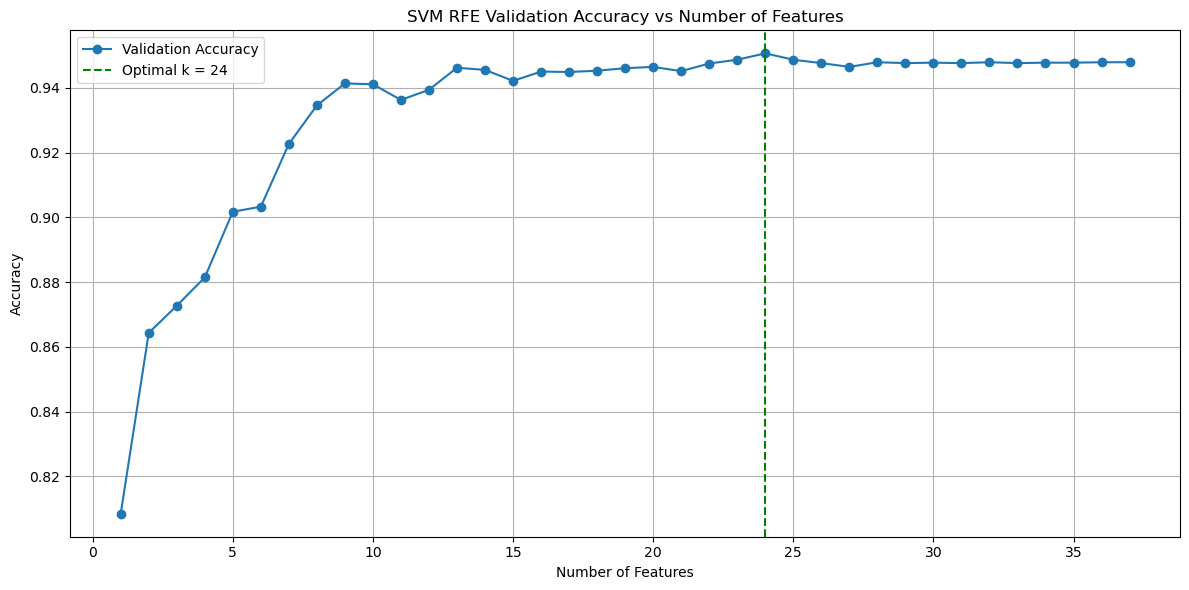

In [ ]:
# Load hasil RFE SVM tanpa repetisi
df_svm = pd.read_csv('../data/output/rfe_val_results_svm_2.csv')

# Karena tidak ada repetisi, buat kolom std dummy = 0
df_svm['std'] = 0

# Ringkas dan buat summary
summary_svm = df_svm.groupby('n_features')['accuracy'].agg(['mean']).reset_index()
summary_svm['std'] = 0

# Cari jumlah fitur dengan akurasi terbaik
best_mean_svm = summary_svm['mean'].max()
k_optimal_svm = summary_svm[summary_svm['mean'] == best_mean_svm]['n_features'].min()

# ✅ Print ringkasan
print(f"✅ Optimal number of features (SVM): {k_optimal_svm}")
print(f"📈 Highest validation accuracy (SVM): {best_mean_svm:.4f}")

# 🔧 Visualisasi
plt.figure(figsize=(12, 6))
plt.plot(summary_svm['n_features'], summary_svm['mean'], marker='o', label='Validation Accuracy')
plt.axvline(x=k_optimal_svm, color='g', linestyle='--', label=f'Optimal k = {k_optimal_svm}')
plt.title('SVM RFE Validation Accuracy vs Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
# Inisialisasi model SVM linear
svm = LinearSVC(C=1.0, max_iter=5000, dual=False, random_state=42)

# Pastikan X_train dalam bentuk DataFrame
feature_names = X_train.columns

k = 5
rfe = RFE(estimator=svm, n_features_to_select=k, step=1)
rfe.fit(X_train, y_train)

# Ambil nama fitur yang terpilih
selected_features = feature_names[rfe.support_]

# Cetak hasil
print(f"\nFitur terpilih untuk k={k} (menggunakan LinearSVC):")
for i, name in enumerate(selected_features, 1):
    print(f"{i}. {name}")



Fitur terpilih untuk k=5 (menggunakan LinearSVC):
1. spectral_centroid_mean
2. spectral_rolloff_mean
3. mfcc_1
4. mfcc_6
5. mfcc_19


In [13]:
selected_features

Index(['chroma_1', 'chroma_4', 'chroma_7', 'chroma_8', 'chroma_11', 'rms_mean',
       'spectral_centroid_mean', 'spectral_bandwidth_mean',
       'spectral_rolloff_mean', 'zcr_mean', 'mfcc_1', 'mfcc_2', 'mfcc_3',
       'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_9', 'mfcc_10', 'mfcc_14',
       'mfcc_17', 'mfcc_18', 'mfcc_19', 'mfcc_20'],
      dtype='object')